# Correr SSD en una imagen

In [1]:
import torchvision
from torchvision import transforms
from PIL import Image
import torch

model = torchvision.models.detection.ssd300_vgg16(pretrained=True)
model.eval()

transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])

img = Image.open("../DeteccionObjetosSSD/imgs/perros.jpg")
x = transform(img).unsqueeze(0)

with torch.no_grad():
    preds = model(x)

print(preds)

c:\SemestreActual\ProyectoIntegrador2\CODELABS-PYI2\codelab6\DeteccionObjetosSSD\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\SemestreActual\ProyectoIntegrador2\CODELABS-PYI2\codelab6\DeteccionObjetosSSD\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[{'boxes': tensor([[  5.7818, 106.5567,  80.8401, 247.3424],
        [170.5440,   3.8363, 293.0857, 289.2744],
        [ 72.9747,  20.6418, 178.8619, 284.2531],
        [164.4342,   6.1380, 294.2430, 294.1174],
        [ 31.7422,  18.6547, 128.4725, 284.0671],
        [ 86.2257, 115.1883, 151.7024, 156.0491],
        [173.2025,   7.6917, 250.6709, 184.0108],
        [237.6662,   0.0000, 296.8437, 152.6069],
        [208.5434,   0.0000, 270.2978,  98.6761],
        [ 11.4921, 160.3247, 294.1080, 296.4497],
        [ 47.0106,  27.1527, 134.6353, 136.0634],
        [ 54.0421, 155.1541,  65.1199, 202.0001],
        [166.7737, 191.2168, 178.6024, 219.0905],
        [167.1519, 189.7586, 196.3953, 260.5803],
        [166.8011, 187.1199, 195.5881, 227.2501],
        [146.2240,  33.6492, 205.5870, 224.0820],
        [183.7275,   6.9072, 280.6054, 113.6153],
        [259.6213, 169.3359, 292.5676, 214.1166],
        [164.4342,   6.1380, 294.2430, 294.1174],
        [123.8787,  16.4516, 237.6274, 

# Visaulizar resultados de SSD

SSD: 0.2775576114654541 seg


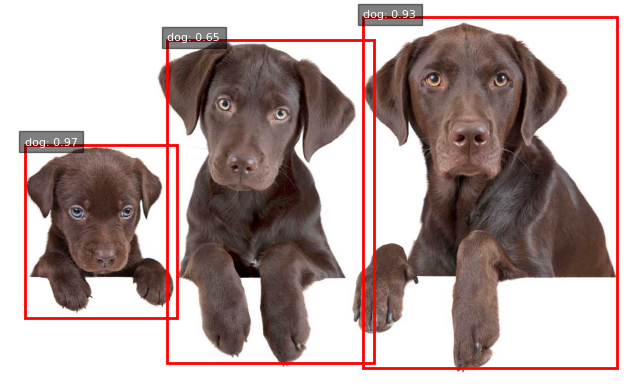

In [2]:
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import time

# Cargar SSD300-VGG16 con pesos preentrenados por defecto (COCO) y ponerlo en modo evaluación para inferencia
weights = SSD300_VGG16_Weights.DEFAULT
model = ssd300_vgg16(weights=weights).eval()

# Transforms correctos (no redimensionan fijo a 300x300, se encargan de escalar de forma consistente). Prepara la imagen igual que durante el entrenamiento (resize, normalización, etc.) para que el modelo la entienda bien
preprocess = weights.transforms()

# Imagen
img = Image.open("../DeteccionObjetosSSD/imgs/perros.jpg").convert("RGB")

# Convierte la imagen en un tensor preprocesado y le agrega la dimensión de batch (1 imagen)
x = preprocess(img).unsqueeze(0)

# Ejecuta el modelo en modo inferencia (sin gradientes) y obtiene las predicciones de la única imagen del batch
with torch.no_grad():
    t0 = time.time()  
    out = model(x)[0]  
    t1 = time.time()  
  
print("SSD:", t1-t0, "seg")

# Boxes ya están en escala original 🎉
boxes, labels, scores = out["boxes"], out["labels"], out["scores"]

# Lista de nombres de clases (COCO) que corresponde a los índices de 'labels' en las predicciones
categories = weights.meta["categories"]

# Visualizar
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.imshow(img)
for box, lab, sc in zip(boxes, labels, scores):
    if sc > 0.5:  # filtrar confianza
        x1, y1, x2, y2 = box.tolist()
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2,
                                 edgecolor="red", facecolor="none")
        ax.add_patch(rect)
        ax.text(x1, y1, f"{categories[int(lab)]}: {sc:.2f}",
                color="white", fontsize=8,
                bbox=dict(facecolor="black", alpha=0.5))
plt.axis("off")
plt.show()

# Comparación con YOLO-lite

In [4]:
from ultralytics import YOLO

model_yolo = YOLO("../DeteccionObjetosSSD/yolov8n.pt")
results = model_yolo("../DeteccionObjetosSSD/imgs/perros.jpg")
results[0].show()


image 1/1 c:\SemestreActual\ProyectoIntegrador2\CODELABS-PYI2\codelab6\DeteccionObjetosSSD\..\DeteccionObjetosSSD\imgs\perros.jpg: 384x640 3 dogs, 1 teddy bear, 34.9ms
Speed: 2.0ms preprocess, 34.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


# Calcular IoU simple

In [5]:
def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB-xA) * max(0, yB-yA)
    boxAArea = (boxA[2]-boxA[0]) * (boxA[3]-boxA[1])
    boxBArea = (boxB[2]-boxB[0]) * (boxB[3]-boxB[1])

    return interArea / float(boxAArea + boxBArea - interArea)

## Reto: 

* Usa al menos 3 imágenes diferentes.
* Haz una tabla comparativa con:
    * Tiempo SSD vs YOLO.
    * Número de objetos detectados.
    * IoU entre las predicciones de ambos.
* Concluye: ¿qué modelo escogerías para un proyecto en tiempo real?

In [14]:
import time
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
from ultralytics import YOLO
import pandas as pd

In [7]:
# ---------------------------------------------
# FUNCIONES
# ---------------------------------------------

def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    inter = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    return inter / (areaA + areaB - inter + 1e-6)

def compute_iou_mean(ssd_boxes, yolo_boxes):
    if len(ssd_boxes) == 0 or len(yolo_boxes) == 0:
        return 0

    ious = []
    for a in ssd_boxes:
        for b in yolo_boxes:
            ious.append(iou(a, b))

    return sum(ious) / len(ious)

In [8]:
# ---------------------------------------------
# CARGAR MODELOS
# ---------------------------------------------

# SSD
weights = SSD300_VGG16_Weights.DEFAULT
model_ssd = ssd300_vgg16(weights=weights).eval()
preprocess = weights.transforms()

# YOLO
model_yolo = YOLO("yolov8n.pt")

In [9]:
# ---------------------------------------------
# IMÁGENES A EVALUAR
# ---------------------------------------------

images = [
    "../DeteccionObjetosSSD/imgs/perros.jpg",
    "../DeteccionObjetosSSD/imgs/grupo.jpg"
]

# TABLA DE RESULTADOS
tabla = []

In [12]:
# ---------------------------------------------
# LOOP SOBRE LAS IMÁGENES
# ---------------------------------------------

for img_path in images:
    img = Image.open(img_path).convert("RGB")

    # ---------------- SSD -----------------
    x = preprocess(img).unsqueeze(0)

    t0 = time.time()
    with torch.no_grad():
        out = model_ssd(x)[0]
    t_ssd = time.time() - t0

    ssd_boxes = out["boxes"].tolist()
    ssd_scores = out["scores"].tolist()
    ssd_boxes = [b for b, s in zip(ssd_boxes, ssd_scores) if s > 0.5]
    n_ssd = len(ssd_boxes)
    
     # ---------------- YOLO ----------------
    t0 = time.time()
    results = model_yolo(img_path)
    t_yolo = time.time() - t0

    yolobox = results[0].boxes.xyxy.cpu().numpy().tolist()
    n_yolo = len(yolobox)

    # ----------- IoU ENTRE MODELOS ----------
    iou_mean = compute_iou_mean(ssd_boxes, yolobox)

    tabla.append([
        img_path,
        round(t_ssd, 4),
        round(t_yolo, 4),
        n_ssd,
        n_yolo,
        round(iou_mean, 4)
    ])


image 1/1 c:\SemestreActual\ProyectoIntegrador2\CODELABS-PYI2\codelab6\DeteccionObjetosSSD\..\DeteccionObjetosSSD\imgs\perros.jpg: 384x640 3 dogs, 1 teddy bear, 39.9ms
Speed: 1.6ms preprocess, 39.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 c:\SemestreActual\ProyectoIntegrador2\CODELABS-PYI2\codelab6\DeteccionObjetosSSD\..\DeteccionObjetosSSD\imgs\grupo.jpg: 448x640 14 persons, 43.8ms
Speed: 1.4ms preprocess, 43.8ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


In [15]:
# ---------------------------------------------
# MOSTRAR TABLA FINAL
# ---------------------------------------------

df = pd.DataFrame(tabla, columns=[
    "Imagen",
    "Tiempo SSD (s)",
    "Tiempo YOLO (s)",
    "Objetos SSD",
    "Objetos YOLO",
    "IoU Promedio"
])

print("\nRESULTADOS FINALES:\n")
print(df)


RESULTADOS FINALES:

                                   Imagen  Tiempo SSD (s)  Tiempo YOLO (s)  \
0  ../DeteccionObjetosSSD/imgs/perros.jpg          0.2255           0.0859   
1   ../DeteccionObjetosSSD/imgs/grupo.jpg          0.2306           0.0526   

   Objetos SSD  Objetos YOLO  IoU Promedio  
0            3             4        0.3125  
1            8            14        0.0997  
